**NLP Analysis - Reviews Data**

# Introduction

## Read in libraries, data, and set notebook preferences

**Read in libraries**

In [102]:
#Read in libraries
import pandas as pd
import swifter

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import gensim


**Read in data**

In [103]:
#Set path to data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\03_Processed'

#Read in data
df = pd.read_csv(path + '/2020_0208_Reviews_Processed_NLP.csv',sep=',',
                 parse_dates=['date'])

**Set preferences for notebook**

In [104]:
#Ignore warnings
import warnings; warnings.simplefilter('ignore')

#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',100)

#Set style for plots
plt.style.use('ggplot')

## Preview data

In [105]:
#Preview data and shape
print('Reviews data shape:', df.shape)
display(df.head())

Reviews data shape: (425509, 7)


,comments,date,sentiment_compound,word_count,comments_pos_tag,comments_lemma,label
0,"Hello Josh Thank you very much for everything. I found myself very comfortable in your home. Quiet, comfortable and very complete and very clean, which I value highly. Next time I'd come with my family. I hope it's possible.",2013-12-01,0.9534,39,"[('hello', 'NN'), ('josh', 'NN'), ('thank', 'VBD'), ('much', 'JJ'), ('everything', 'NN'), ('comfortable', 'JJ'), ('home', 'NN'), ('quiet', 'RBR'), ('comfortable', 'JJ'), ('complete', 'JJ'), ('clean', 'JJ'), ('highly', 'RB'), ('next', 'JJ'), ('time', 'NN'), ('come', 'VBN'), ('possible', 'JJ')]","['hello', 'josh', 'thank', 'much', 'everything', 'comfortable', 'home', 'quiet', 'comfortable', 'complete', 'clean', 'highly', 'next', 'time', 'come', 'possible']",positive
1,"Stop and book it now. Rea (Website hidden by Airbnb) this later!!! If your a single person looking for a story book San Francisco experience, look no farther. Staying in Mikes place couldn't be any more wonderful. If your familiar with ""Tales of the City"" Mike is the Olympia Dukakis. The home is warm and inviting with all the nuances of an old Victorian. Mike is an amazing host . He can tell you how walk drive or public transit the city (don't bother with a car). Would love to keep the gem to myself but everyone deserves this unique place to lay your head. Make sure while you're there be introduced to William . Book IT you won't be disappointed .",2017-06-07,0.9334,122,"[('stop', 'VB'), ('book', 'NN'), ('rea', 'JJ'), ('website', 'RB'), ('hidden', 'VBP'), ('later', 'RB'), ('person', 'NN'), ('looking', 'VBG'), ('book', 'NN'), ('san', 'JJ'), ('francisco', 'JJ'), ('experience', 'NN'), ('look', 'NN'), ('staying', 'VBG'), ('place', 'NN'), ('wonderful', 'NN'), ('familiar', 'JJ'), ('tales', 'NNS'), ('city', 'NN'), ('mike', 'NN'), ('olympia', 'VBP'), ('dukakis', 'NN'), ('home', 'NN'), ('inviting', 'NN'), ('nuances', 'NNS'), ('old', 'JJ'), ('victorian', 'JJ'), ('mike', 'NN'), ('amazing', 'VBG'), ('host', 'NN'), ('tell', 'NN'), ('walk', 'VBP'), ('drive', 'JJ'), ('transit', 'NN'), ('city', 'NN'), ('would', 'MD'), ('love', 'VB'), ('gem', 'NN'), ('everyone', 'NN'), ('deserves', 'VBZ'), ('unique', 'JJ'), ('place', 'NN'), ('head', 'NN'), ('make', 'VBP'), ('sure', 'JJ'), ('book', 'NN'), ('disappointed', 'VBD')]","['stop', 'book', 'rea', 'website', 'hide', 'later', 'person', 'look', 'book', 'san', 'francisco', 'experience', 'look', 'stay', 'place', 'wonderful', 'familiar', 'tale', 'city', 'mike', 'olympia', 'dukakis', 'home', 'inviting', 'nuance', 'old', 'victorian', 'mike', 'amaze', 'host', 'tell', 'walk', 'drive', 'transit', 'city', 'would', 'love', 'gem', 'everyone', 'deserve', 'unique', 'place', 'head', 'make', 'sure', 'book', 'disappoint']",positive
2,"So I moved to SF in late May from Michigan to intern at Genentech for the summer. I stayed at Anjan’s apartment for 7 days while I was looking for a more permanent housing situation. Anjan was extremely hospitable and welcoming throughout the week. He was also very knowledgeable about the area and always offered to help in any way that he could. The area (SOMA) is very safe and is very “walkable.” There are plenty of restaurants and stores nearby (there’s even a target a few blocks away), so you have everything you need within a couple blocks from the apartment. As for the bedroom, it was spacious and clean. The bathroom was nice and I had to myself for the entirety of my stay. I felt very comfortable living at Anjan’s for a week and I really enjoyed staying there. If you’re a respectful person and are looking for a place to stay in SF for a short time, I highly recommend staying at Anjan’s. He’s a great person and a great host.",2013-06-02,0.9860,175,"[('moved', 'VBN'), ('may', 'MD'), ('michigan', 'VB'), ('summer', 'NN'), ('days', 'NNS'), ('looking', 'VBG'), ('permanent', 'JJ'), ('housing', 'NN'), ('situation', 'NN'), ('anjan', 'VBZ'), ('extremely', 'RB'), ('hospitable', 'JJ'), ('welcoming', 'VBG')

# DELETE THIS

In [106]:
df=df[::10]

# Data Exploration

### Histogram of sentiment scores

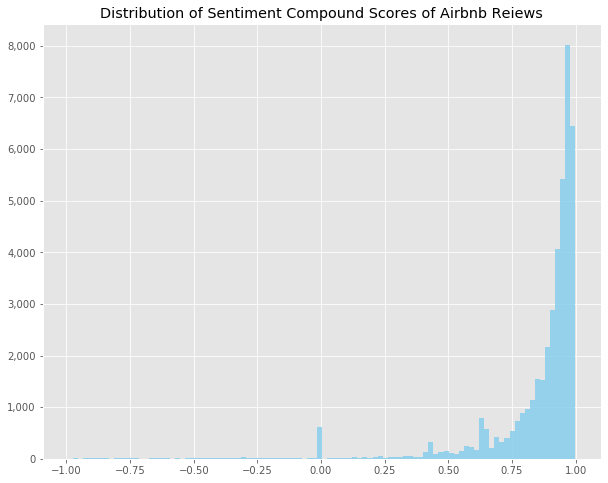

In [107]:
#Set plot
fig, ax = plt.subplots(figsize = (10,8))

#Plot hist of sentiment_compound scores
j = df.sentiment_compound.hist(ax = ax,bins = 100, color = 'skyblue', alpha = .85)

#Set plot aesthetics
j.set_title('Distribution of Sentiment Compound Scores of Airbnb Reiews')
ax.set_yticklabels(['{:,}'.format(int(y)) for y in ax.get_yticks()]);

### Positive, neutral, and negative review counts

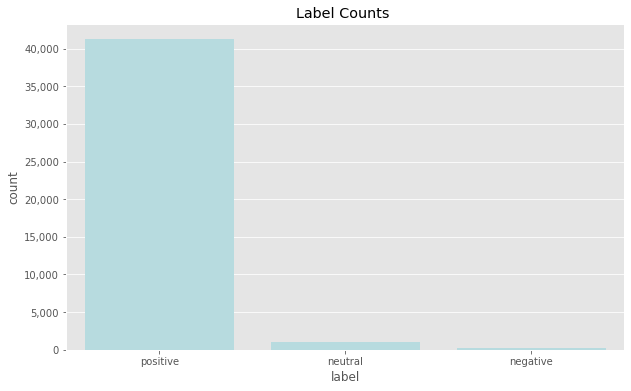

In [108]:
#Set plot
fig, ax = plt.subplots(figsize=(10,6))

#plot data
g =sns.countplot(x='label', data = df,order = ['positive', 'neutral', 'negative'], color='powderblue')

#Set plot aesthetics
g.set_title('Label Counts ')
g.set_yticklabels(['{:,}'.format(int(y)) for y in ax.get_yticks()]);

### Distribution of review lengths for positive and negative reviews

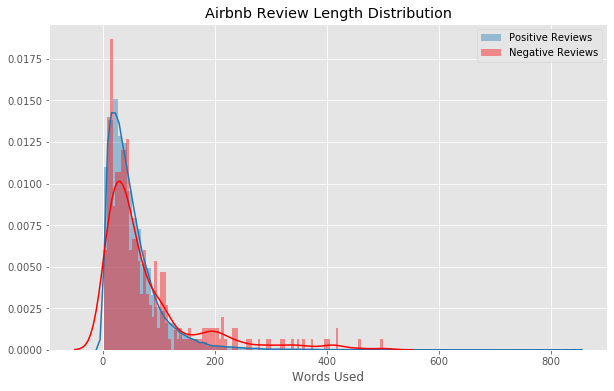

In [109]:
#Set plot
fig, ax = plt.subplots(figsize=(10,6))

#Plot Histograms for word count
sns.distplot(df.word_count.loc[df['label'] == 'positive'], kde = True, bins = 100, color = 'tab:blue', ax=ax)
sns.distplot(df.word_count.loc[df['label'] == 'negative'], kde = True, bins = 100, color = 'r', ax=ax)

#Set plot aesthetics
ax.legend(labels = ['Positive Reviews', 'Negative Reviews', 'Neutral Reviews'], frameon = True);
ax.set_title('Airbnb Review Length Distribution')
ax.set_xlabel('Words Used');

### Word clouds of positive and negative reviews

In [110]:
#Import libraries 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

**Postive Reviews Wordcloud**

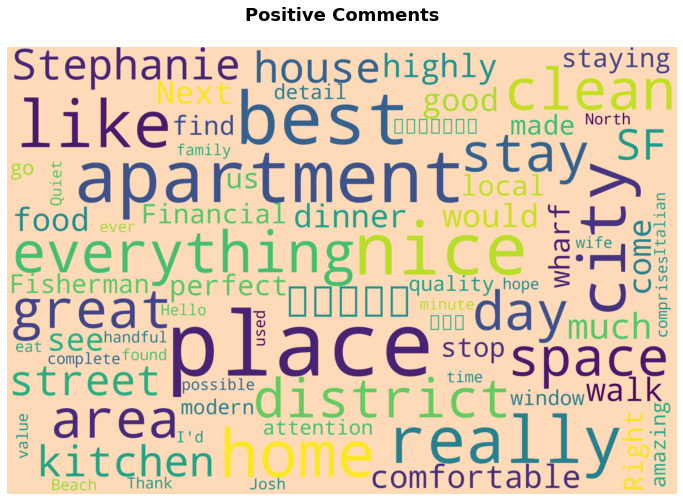

In [111]:
#Import stopwords
from nltk.corpus import stopwords, wordnet
stop_words = stopwords.words('english')

#Add additional stop words
stop_words.extend(['airbnb','website hidden by airbnb'])

#Create wordcloud for postive reviews
wordcloud = WordCloud(max_font_size=400, max_words=75, background_color="peachpuff", stopwords=stop_words,
                      width= 3000, height = 2000).generate(str(df.comments.loc[df['label'] == 'positive'].values))

#Plot data and set plot aesthetics
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Positive Comments\n', fontsize=18, fontweight='bold')
plt.show()



**Negative Reviews Wordcloud**

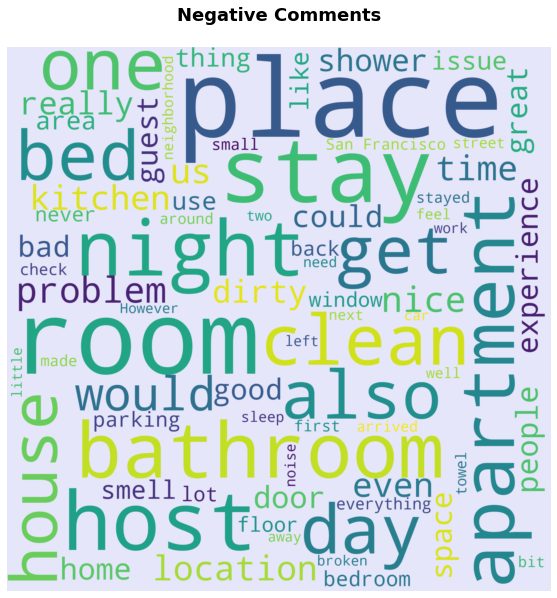

In [112]:
#Create wordcloud for postive reviews
wordcloud = WordCloud(max_font_size=400, max_words=75, background_color="lavender",stopwords=stop_words,
                      width= 2000, height = 2000).generate(str(df.comments.loc[df['label'] == 'negative'].values))

#Plot data and set plot aesthetics
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Negative Comments\n', fontsize=18, fontweight='bold')
plt.show()

# Topic modeling and document clustering for postive reviews

## Data preparation

### Import libraries

In [113]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt

### Clean and tokenize comments

In [114]:
#Convert comments to a list
reviews = df['comments']

#Check
print(reviews[:3])

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Hello Josh  Thank you very much for everything. I found myself very comfortable in your home. Quiet, comfortable and very complete and very clean, which I value highly. Next time I'd come with my family. I hope it's poss

In [115]:
#Tokenize each sentence into a list of words and remove punctuation
def tokenizer(raw_reviews):
    for review in raw_reviews:
        yield(gensim.utils.simple_preprocess(review, deacc=True))
        
tokens = list(tokenizer(reviews))

In [116]:
print(tokens[0])

['hello', 'josh', 'thank', 'you', 'very', 'much', 'for', 'everything', 'found', 'myself', 'very', 'comfortable', 'in', 'your', 'home', 'quiet', 'comfortable', 'and', 'very', 'complete', 'and', 'very', 'clean', 'which', 'value', 'highly', 'next', 'time', 'come', 'with', 'my', 'family', 'hope', 'it', 'possible']


In [123]:
#Remove stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

tokens_clean = remove_stopwords(tokens)

#Check
print(tokens_clean[0])

['hello', 'josh', 'thank', 'much', 'everything', 'found', 'comfortable', 'home', 'quiet', 'comfortable', 'complete', 'clean', 'value', 'highly', 'next', 'time', 'come', 'family', 'hope', 'possible']


Creating Bigram and Trigram Models

In [118]:
#Build bigram and trigram models
bigram = gensim.models.Phrases(tokens_clean,min_count=5, threshold=100)#Might need to increse with full data set
trigram = gensim.models.Phrases(bigram[tokens_clean], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [119]:
#Check
print(trigram_mod[bigram_mod[tokens_clean[2]]])

['great', 'stay', 'stephanie', 'apartment', 'first', 'well', 'placed', 'adventures', 'around', 'every', 'corner', 'find', 'comfort', 'quality', 'attention_detail', 'made', 'day', 'really', 'modern', 'place', 'furnishings', 'fixtures', 'carefully', 'chosen', 'modern', 'recliners', 'couches', 'rugs', 'flooring', 'appliances', 'window', 'covering', 'stonework', 'woodwork', 'give', 'put_together', 'feeling', 'decor', 'bright', 'cheerful', 'welcoming', 'including', 'fresh_flowers', 'enjoyed', 'state_art', 'shower', 'kitchen', 'stephanie', 'thought', 'everything', 'make', 'accommodation', 'pleasant', 'also', 'relief', 'kitchen', 'bath', 'stocked', 'necessities', 'forget', 'packing', 'beds', 'linens', 'towels', 'really', 'everything', 'best', 'quality', 'extra', 'pillows_blankets', 'right', 'hand', 'came', 'home', 'thinking', 'want', 'house', 'like', 'apartment', 'windows', 'let', 'lot', 'light', 'look', 'garden', 'bursting', 'tropical', 'plants', 'sliding_doors', 'nice', 'space', 'eating', '

Make bigrams, trigrams and lemmatize 

In [127]:
#Create functions to create bi/trigrams.
def bigrams(tokens):
    return[bigram_mod[token] for token in tokens]

def trigrams(tokens):
    return[trigram_mod[bigram_mod[token]] for token in tokens]

#Write function that pos tags token and lemmatizes words with proper tags
def lemmatization(tokens, postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for token in tokens:
        doc = nlp(" ".join(token)) 
        texts_out.append([token.lemma_ for token in tokens if token.pos_ in allowed_postags])
    return texts_out

In [146]:
#Create bigrams
bigrams = bigrams(tokens_clean)

#Create trigrams
trigrams = trigrams(tokens_clean)

TypeError: 'list' object is not callable

In [128]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#apply lemmatization keeping only noun, adj, vb, adv to bigrams and trigrams
bigrams_lemmatized = lemmatization(bigrams)
trigrams_lemmatized = lemmatization(trigrams)

print(bigrams_lemmatized[:1])

AttributeError: 'list' object has no attribute 'pos_'

Create the Dictionary and Corpus needed for Topic Modeling

View the topics in LDA model

AttributeError: 'list' object has no attribute 'startswith'

Visualize 

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(df.comments_lemma)

# # Create Corpus
# texts = data_lemmatized

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]

# # View
# print(corpus[:1])

Top unigrams

Top bigrams

Top Trigrams

In [ ]:
#What are the most popular words in positive reviews?

In [ ]:
#Import count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english').fit(positive_reviews.comments)

print('Vocabulary used in positive reviews: {}'.format(len(count.vocabulary_)))

bow = count.transform(positive_reviews.comments)
sum_words = bow.sum(axis=0)

#we sort a list of tuples that contain the word and their occurrence in the corpus
words_freq = [(word, sum_words[0, idx]) for word, idx in count.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

# Topic modeling and document clustering for postive reviews

In [147]:
#Import libraries
import gensim
from gensim.parsing.preprocessing import preprocess_string
from gensim.models import Phrases
from gensim import corpora, models, similarities

In [ ]:
#Apply preprocess and stem original comments
docs = np.array(positive_reviews['comments'].apply(preprocess_string))

# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [ ]:
#Create dictionary of tokens and print info
dictionary = corpora.Dictionary(docs)
print('Number of unique words in original documents: {}'.format(len(dictionary)))

**Remove rare or common tokens**

In [ ]:
#Filter words that occur in less than 10 documents or more than 25% of documents
dictionary.filter_extremes(no_below= 10,no_above=.25 )

print('Number of unique words after removing rare and common words: {}'.format(len(dictionary)))

In [ ]:
#Vectorize data
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
#Initialize Tfidf and fit to corpus
tfidf = models.TfidfModel(corpus)

#Scale and transform corpus
transformed_tfidf = tfidf[corpus]

#Fit transformed data to Lda
lda = models.LdaMulticore(corpus= transformed_tfidf, num_topics=10, id2word=dictionary)

In [ ]:
#Import pyLDAvis to visualize topics found in LDA
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

#Create plot
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
vis

**Takeaways**

## Negative Reviews

In [ ]:
#Preview some of the negative reviews
negative_reviews.comments[10:15]

**Wordcloud of negative comments**

In [ ]:
#Create wordcloud
wordcloud = WordCloud(max_font_size=300, max_words=50, background_color="lightgray",
                      width= 3000, height = 2000).generate(str(df.comments_lemma.loc[df['label'] == 'negative'].values))

#Plot wordcloud
plot_wordcloud(wordcloud, '\nNegatively Tuned')

#What are the most popular words in negative reviews?

In [ ]:
#Instantiate CountVectorizer and fit to comments
count = CountVectorizer(stop_words='english').fit(df.comments)

#Print length of unique words in negative comments
print('Vocabulary used in negative reviews: {}'.format(len(count.vocabulary_)))

#Create bag of words from comments
bow = count.transform(negative_reviews.comments)
sum_words = bow.sum(axis=0)

#we sort a list of tuples that contain the word and their occurrence in the corpus
words_freq = [(word, sum_words[0, idx]) for word, idx in count.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [ ]:
#Create df with vocab and their corresponding counts 
negative_words = pd.DataFrame(words_freq, columns =['Word', 'Count']) 

In [ ]:
#Capture the 30 most used words
negative_words = negative_words.head(30)

#Plot
fig,ax = plt.subplots(figsize = (10,10))
negative_words.sort_values(by='Count').plot(x = 'Word',y='Count',kind='barh', ax=ax, color = 'skyblue')

#Set plot aesthetics
ax.set_title('Most Common Words used in Negative Airbnb Reviews')
ax.set_ylabel('')

In [ ]:
#Topic modeling for negative reviews

In [ ]:
#Apply preprocess and stem original comments
docs = np.array(df['comments'].apply(preprocess_string))

# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [ ]:
#Create dictionary of tokens and print info
dictionary = corpora.Dictionary(docs)
print('Number of unique words in original documents: {}'.format(len(dictionary)))

**Remove rare or common tokens**

In [ ]:
#Filter words that occur in less than 10 documents or more than 25% of documents
dictionary.filter_extremes(no_below= 10,no_above=.25 )

print('Number of unique words after removing rare and common words: {}'.format(len(dictionary)))

In [ ]:
#Vectorize data
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
#Initialize Tfidf and fit to corpus
tfidf = models.TfidfModel(corpus)

#Scale and transform corpus
transformed_tfidf = tfidf[corpus]

#Fit transformed data to Lda
lda = models.LdaMulticore(corpus= transformed_tfidf, num_topics=10, id2word=dictionary)

In [ ]:
#Create plot
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
vis

Build classifier that can classify postive and negative reviews
What words are the most important to each?

In [ ]:
#what insights can you gain?

Extract Additional insights from Comments (NLP book chapter 7)